# Reading Data and computing $U,V$

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
% matplotlib inline

/usr/local/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [3]:
# uses joeys code copypastad from his notebook, should ideally put this in a data utils or something
with open('data/movies.txt', 'r') as f:
    movies = f.read().split('\r')
with open ('data/data.txt', 'r') as f:
    ratings = f.read().split('\r')

movies_list = []
for m in movies:
    movies_list.append(m.split('\t'))

ratings_list = []
for r in ratings:
    ratings_list.append(r.split('\t'))

movies_df = pd.DataFrame(movies_list, columns = ['Movie Id', 'Movie Title', 'Unknown', 'Action', \
                                                 'Adventure', 'Animation', 'Childrens', \
                                                 'Comedy', 'Crime', 'Documentary', 'Drama', \
                                                 'Fantasy', 'Film-Noir', 'Horror', \
                                                 'Musical', 'Mystery', 'Romance', \
                                                 'Sci-Fi', 'Thriller', 'War', \
                                                 'Western'])


ratings_df =  pd.DataFrame(ratings_list, columns = ['User Id', 'Movie Id', 'Rating'])

movies_df =  movies_df.apply(pd.to_numeric, errors='ignore')
ratings_df = ratings_df.apply(pd.to_numeric)
r_df = ratings_df.pivot(index = 'Movie Id', columns ='User Id', values = 'Rating').fillna(0)

In [4]:
# currently uses rohan's code for factorization, may not be ideal but can replace later
from factorize import factor_matrix,error # now uses joey's updated code with biases

In [5]:
# write the list of movie titles as they appear to a file, so we can search for them later
movie_titles = movies_df["Movie Title"].values
f = open('movie_titles.txt', 'w')
f.writelines(["%s\n" % item  for item in movie_titles])

In [16]:
k = 20 # use 20 latent factors
reg_val = .05 # empirically from plots this was good
ratings = np.loadtxt('data/ratings.out',delimiter=',')
mean_rating = np.mean(ratings[np.nonzero(ratings)])
# Take out mean of all ratings
ratings_normed = ratings.copy()
ratings_normed[np.nonzero(ratings_normed)] -= mean_rating

U, V, a, b = factor_matrix(ratings_normed, 20, reg = reg_val)

0 0.941629340125
1 0.859886352472
2 0.820093479613
3 0.794476423313
4 0.773875964218
5 0.755970623846
6 0.738430083159
7 0.720558269217
8 0.70255320805
9 0.684949694848
10 0.667398721483
11 0.650611024044
12 0.634832341927
13 0.619653447247
14 0.605714801628
15 0.5922272524
16 0.579961516846
17 0.568504415782
18 0.557882437428
19 0.547804633426
20 0.538359493805
21 0.529866012867
22 0.521987674614
23 0.514477839413
24 0.507587126189
25 0.50088052504
26 0.49508643463
27 0.489569310979
28 0.484412515122
29 0.479764170146
30 0.474652753105
31 0.470398287903
32 0.466667352921
33 0.462788858292
34 0.459159569486
35 0.455585243875
36 0.452337446496
37 0.449701603487
38 0.446763212562
39 0.444305285833
40 0.44139972342
41 0.438818095272
42 0.436630224704
43 0.434526304234
44 0.432521490735
45 0.430250148613
46 0.428409223009
47 0.426363579964
48 0.424485024032
49 0.422761244784
50 0.420970484254


In [17]:
# get SVD of V and project it
a,b,c = np.linalg.svd(V)
print np.shape(a)
print np.shape(b)
print np.shape(c)

print np.shape(V) # V has the movies
V_proj = np.dot(V,c[:2].T)
print np.shape(V_proj)

(1682, 1682)
(20,)
(20, 20)
(1682, 20)
(1682, 2)


Now we have latent vectors U and V, projected into 2-d space. We want to visualize them. U contains features for each movie, while V contains features for each user. 

# Ten Random Movies

In [9]:
inds = np.random.choice(range(1682),10)
vals = V_proj[inds]
xs = vals[:,0]
ys = vals[:,1]
titles = np.array(movies_df["Movie Title"].tolist())[inds] # gets 10 random movies

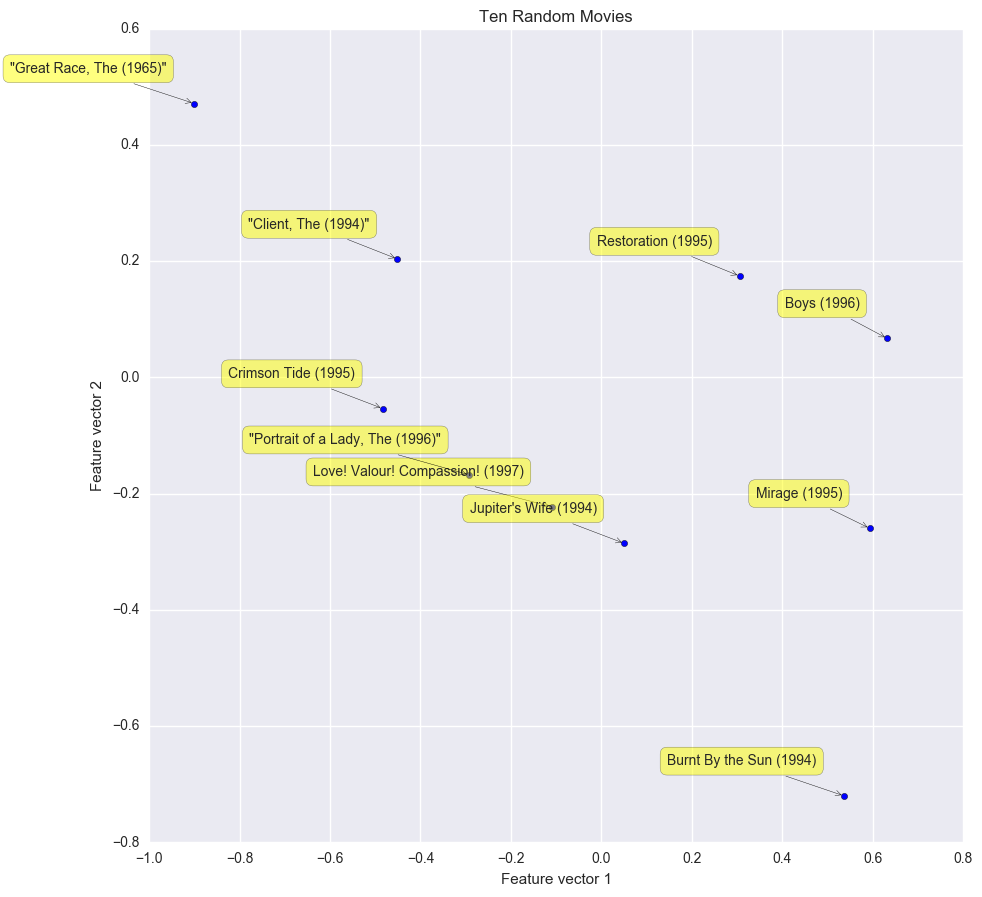

In [10]:
plt.scatter(xs, ys, marker='o')

for label, x, y in zip(titles, xs, ys): # probably should fix this up to be better
    plt.annotate(
        label,
        xy=(x, y), xytext=(-20, 20),
        textcoords='offset points', ha='right', va='bottom',
        bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
        arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0'))
fig = plt.gcf()
fig.set_size_inches(10.5, 10.5)
plt.title("Ten Random Movies")
plt.xlabel("Feature vector 1")
plt.ylabel("Feature vector 2")
plt.savefig("ten_random.png")

# Ten Most Popular Movies

In [13]:
r_df['Total Ratings'] = (r_df != 0).sum(axis=1)
ten_most_popular = r_df.sort_values('Total Ratings', ascending=False)[:10].index
ten_most_popular_inds = np.array(ten_most_popular)-1
vals = V_proj[ten_most_popular_inds]
xs = vals[:,0]
ys = vals[:,1]
titles = np.array(movies_df["Movie Title"].tolist())[ten_most_popular_inds] 

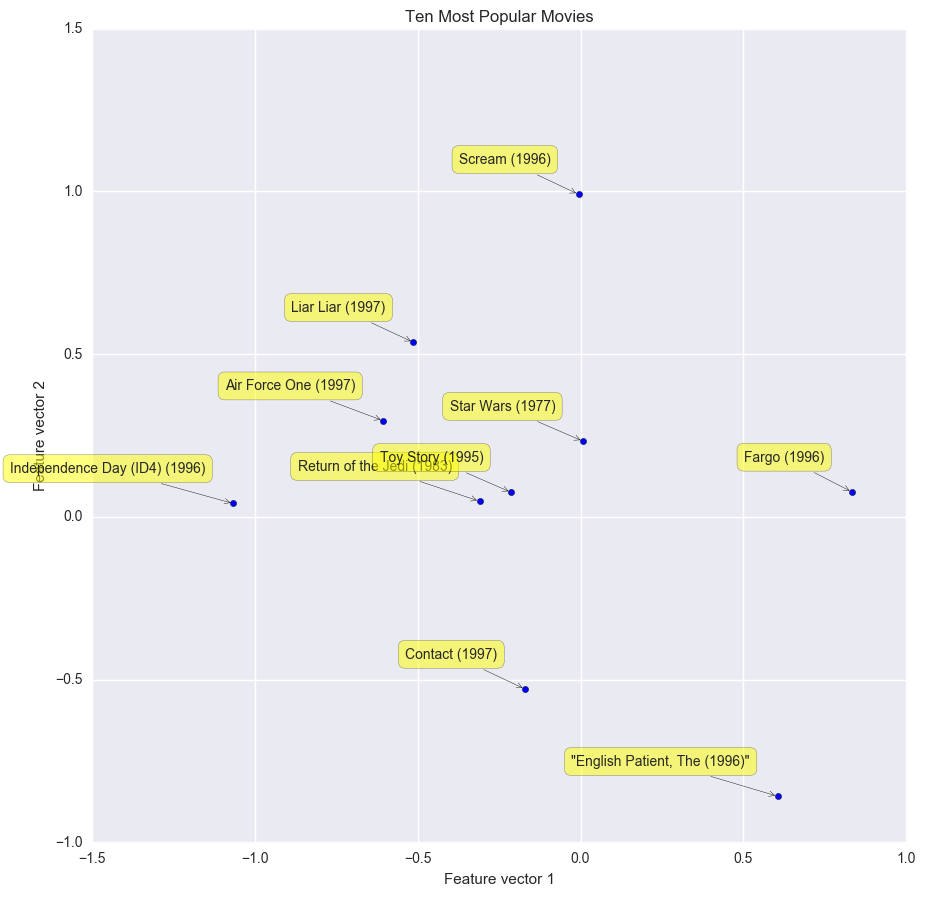

In [14]:
plt.scatter(xs, ys, marker='o')

for label, x, y in zip(titles, xs, ys): # probably should fix this up to be better
    plt.annotate(
        label,
        xy=(x, y), xytext=(-20, 20),
        textcoords='offset points', ha='right', va='bottom',
        bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
        arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0'),rotation = 0)
fig = plt.gcf()
fig.set_size_inches(10.5, 10.5)
plt.title("Ten Most Popular Movies")
plt.xlabel("Feature vector 1")
plt.ylabel("Feature vector 2")
plt.savefig("ten_most_popular.png")

# Ten best movies 

In [15]:
r_filtered_df = r_df[r_df['Total Ratings'] >= 5].drop(['Total Ratings'], axis=1)
r_filtered_df['Average Rating'] = r_filtered_df.replace(0, np.nan).mean(axis=1)
r_filtered_df.sort_values(['Average Rating'], ascending=False)[:10]
ten_best = r_filtered_df.sort_values(['Average Rating'], ascending=False)[:10].index
ten_best_inds = np.array(ten_best) -1
vals = V_proj[ten_best_inds]
xs = vals[:,0]
ys = vals[:,1]
titles = np.array(movies_df["Movie Title"].tolist())[ten_best_inds] 

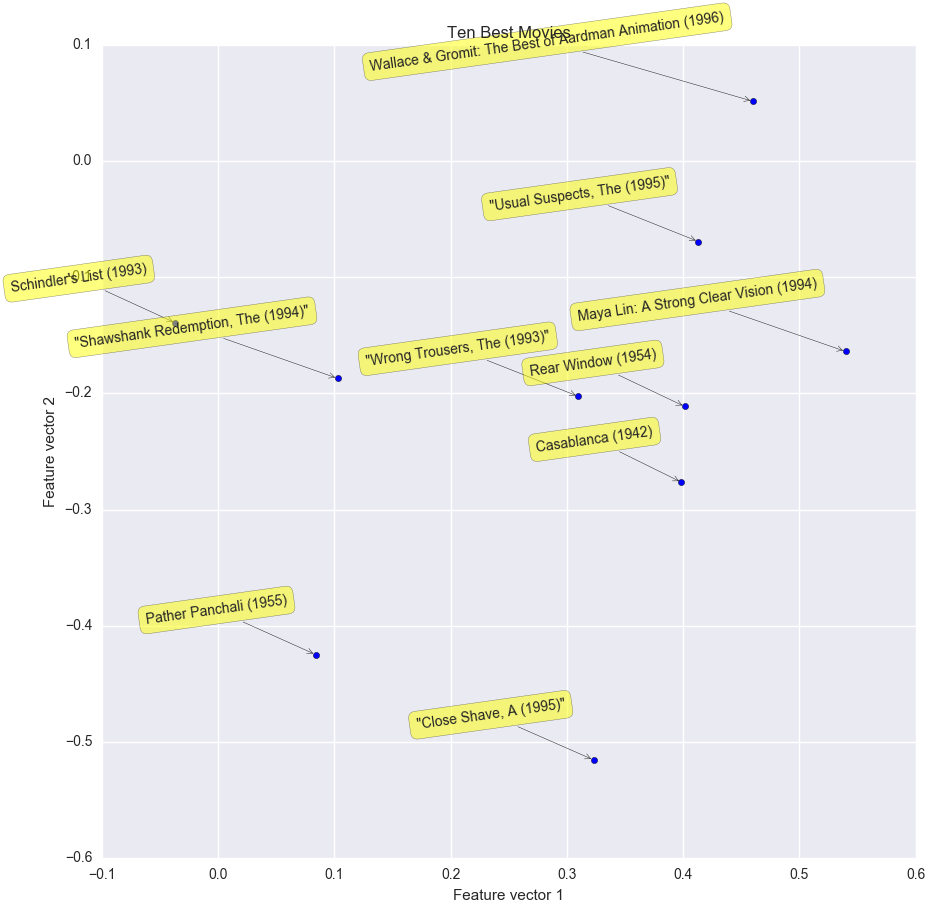

In [17]:
plt.scatter(xs, ys, marker='o')

for label, x, y in zip(titles, xs, ys): # probably should fix this up to be better
    plt.annotate(
        label,
        xy=(x, y), xytext=(-20, 20),
        textcoords='offset points', ha='right', va='bottom',
        bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
        arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0'),rotation=8)
    
fig = plt.gcf()
fig.set_size_inches(10.5, 10.5)
plt.title("Ten Best Movies")
plt.xlabel("Feature vector 1")
plt.ylabel("Feature vector 2")
plt.savefig("ten_best.png")

# Ten Best from 3 genres

In [18]:
genres = ['Drama', 'Comedy', 'Thriller'] #top 3 most popular genres

## Drama 

In [19]:
drama_movies = movies_df[movies_df['Drama'] == 1]['Movie Id'].values
drama_movies_inds = np.random.choice(np.array(drama_movies)-1,10)
# pick ten random ones, can do ten best or ten most pop later
vals = V_proj[drama_movies_inds]
xs = vals[:,0]
ys = vals[:,1]
titles = np.array(movies_df["Movie Title"].tolist())[drama_movies_inds]

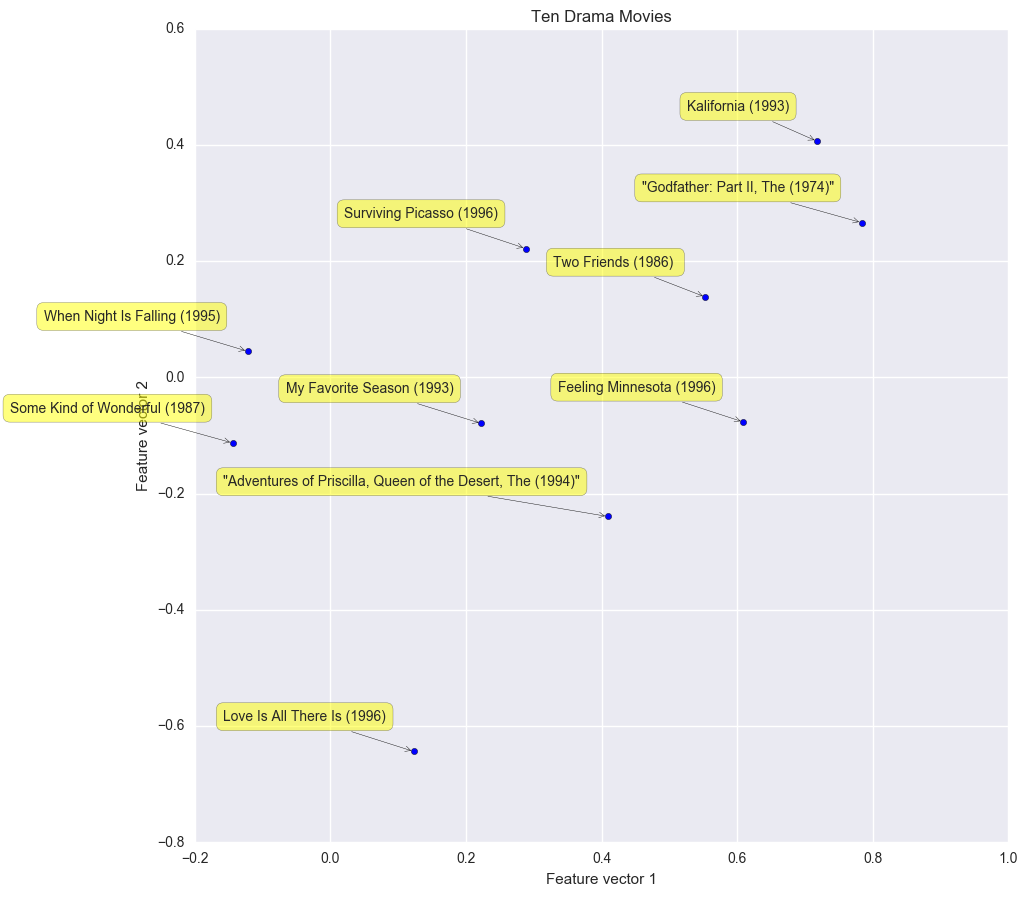

In [20]:
plt.scatter(xs, ys, marker='o')

for label, x, y in zip(titles, xs, ys): # probably should fix this up to be better
    plt.annotate(
        label,
        xy=(x, y), xytext=(-20, 20),
        textcoords='offset points', ha='right', va='bottom',
        bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
        arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0'),rotation = 0)
fig = plt.gcf()
fig.set_size_inches(10.5, 10.5)
plt.title("Ten Drama Movies")
plt.xlabel("Feature vector 1")
plt.ylabel("Feature vector 2")
plt.savefig("ten_random_drama.png")

## Comedy 

In [23]:
comedy_movies = movies_df[movies_df['Comedy'] == 1]['Movie Id'].values
comedy_movies_inds = np.random.choice(np.array(comedy_movies)-1,10)
# pick ten random ones, can do ten best or ten most pop later
vals = V_proj[comedy_movies_inds]
xs = vals[:,0]
ys = vals[:,1]
titles = np.array(movies_df["Movie Title"].tolist())[comedy_movies_inds]

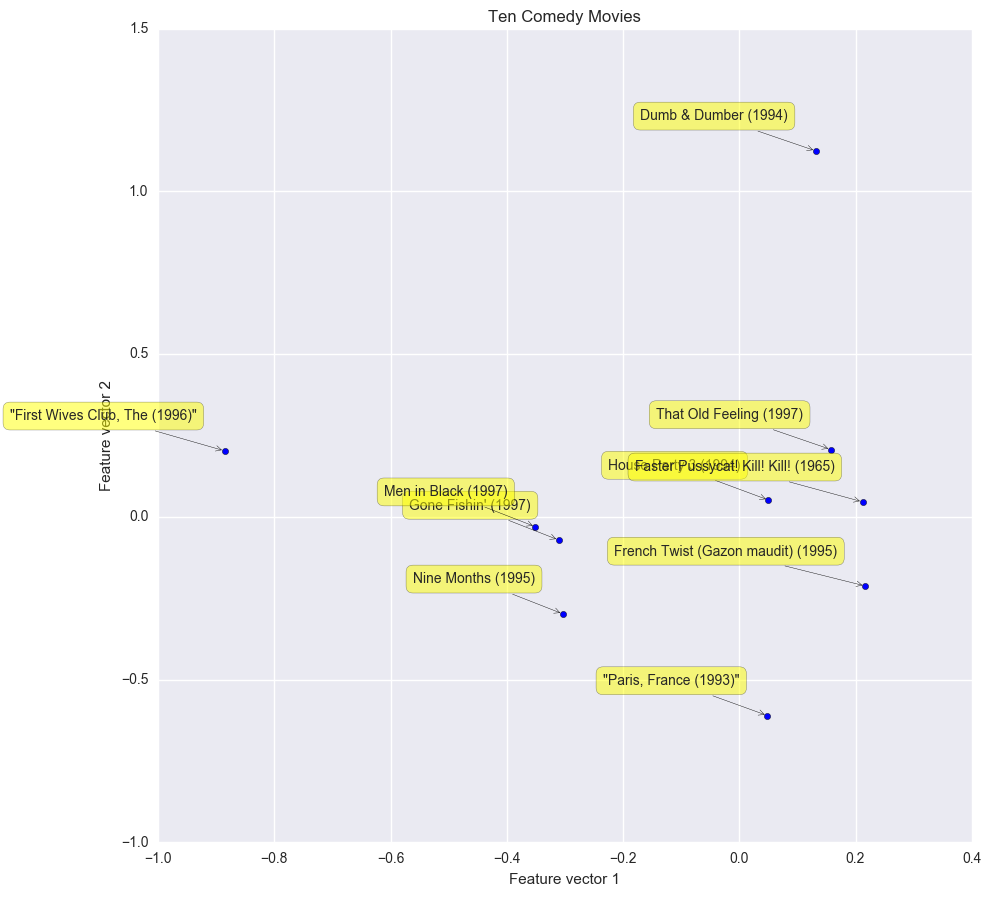

In [24]:
plt.scatter(xs, ys, marker='o')

for label, x, y in zip(titles, xs, ys): # probably should fix this up to be better
    plt.annotate(
        label,
        xy=(x, y), xytext=(-20, 20),
        textcoords='offset points', ha='right', va='bottom',
        bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
        arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0'),rotation =0)

fig = plt.gcf()
fig.set_size_inches(10.5, 10.5)
plt.title("Ten Comedy Movies")
plt.xlabel("Feature vector 1")
plt.ylabel("Feature vector 2")
plt.savefig("ten_random_comedy.png")

## Thriller

In [75]:
thriller_movies = movies_df[movies_df['Thriller'] == 1]['Movie Id'].values
thriller_movies_inds = np.random.choice(np.array(thriller_movies)-1,10)
# pick ten random ones, can do ten best or ten most pop later
vals = V_proj[thriller_movies_inds]
thrill_xs = vals[:,0]
thrill_ys = vals[:,1]
thrill_titles = np.array(movies_df["Movie Title"].tolist())[thriller_movies_inds]

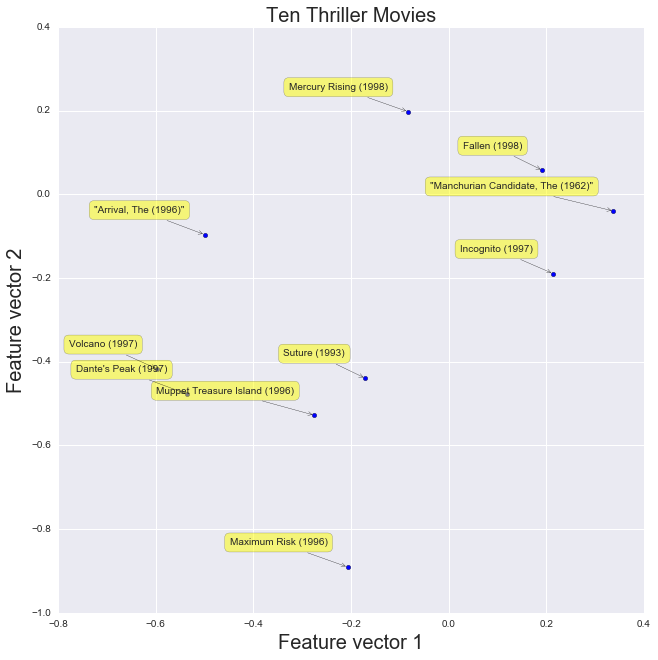

In [76]:
plt.scatter(thrill_xs, thrill_ys, marker='o')

for label, x, y in zip(thrill_titles, thrill_xs, thrill_ys): # probably should fix this up to be better
    plt.annotate(
        label,
        xy=(x, y), xytext=(-20, 20),
        textcoords='offset points', ha='right', va='bottom',
        bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
        arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0'))

fig = plt.gcf()
fig.set_size_inches(10.5, 10.5)
plt.title("Ten Thriller Movies",fontsize = 20)
plt.xlabel("Feature vector 1",fontsize = 20)
plt.ylabel("Feature vector 2",fontsize = 20)
plt.savefig("ten_random_thriller.png")

In [18]:
# create the plot that Yisong made (1)
titles = movies_df["Movie Title"].values
yisong_movies = [
    "My Fair Lady (1964)",
    "Free Willy 2: The Adventure Home (1995)", # lmao required 'the adventure home'
    "Free Willy (1993)",
    "Batman Forever (1995)",
    "Bad Boys (1995)",
    "\"Birdcage, The (1996)\"",
    "Star Wars (1977)",
    "Return of the Jedi (1983)",
    "\"Empire Strikes Back, The (1980)\"", # lol quotes
    "\"Nutty Professor, The (1996)\"",
    "GoldenEye (1995)",
    "Apollo 13 (1995)",
    "Twelve Monkeys (1995)",
    "2001: A Space Odyssey (1968)",
    "Fargo (1996)",
    "Seven (Se7en) (1995)",
    "Aliens (1986)",
    "Braveheart (1995)",
    "Forrest Gump (1994)"
]
inds = []
for movie in yisong_movies:
    inds.append(list(titles).index(movie))
vals = V_proj[inds]
yisong_xs = vals[:,0]
yisong_ys = vals[:,1]
yisong_titles = np.array(movies_df["Movie Title"].tolist())[inds]

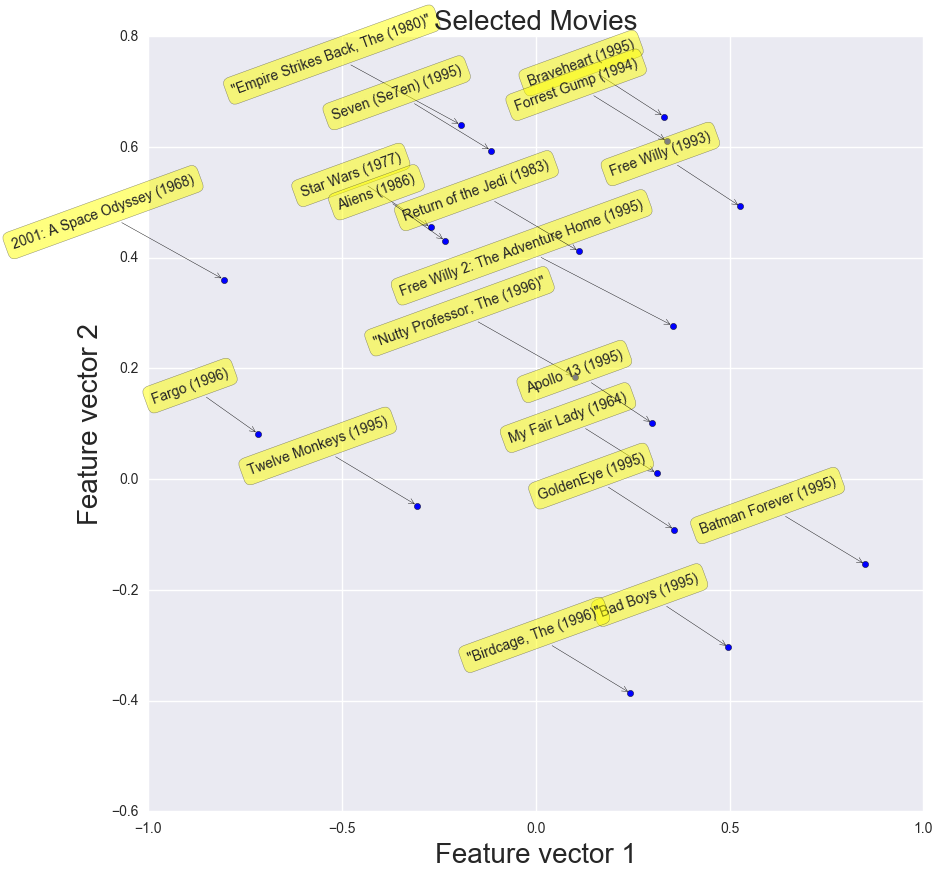

In [20]:
plt.scatter(yisong_xs, yisong_ys, marker='o')

for label, x, y in zip(yisong_titles, yisong_xs, yisong_ys): # probably should fix this up to be better
    plt.annotate(
        label,
        xy=(x, y), xytext=(-20, 20),
        textcoords='offset points', ha='right', va='bottom',
        bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
        arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0'),rotation = 20)

fig = plt.gcf()
fig.set_size_inches(10, 10)
plt.title("Selected Movies",fontsize = 20)
plt.xlabel("Feature vector 1",fontsize = 20)
plt.ylabel("Feature vector 2",fontsize = 20)
plt.savefig("choice_movies.png")